# Investigating Churn to Reduce Employee Turnover

Imports

In [2]:
# Data manipulation
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# For ignoring warnings
import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis

In [3]:
df1 = pd.read_csv("../../turnover.csv", engine = "python", encoding = "ISO-8859-1")

In [4]:
df1.head()

,stag,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
0,7.030801,1,m,35.0,Banks,HR,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3
1,22.965092,1,m,33.0,Banks,HR,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3
2,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3
3,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7
4,8.410678,1,m,32.0,Retail,Commercial,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7


In [5]:
df1.shape

(1129, 16)

In [6]:
df1.dtypes

stag            float64
event             int64
gender           object
age             float64
industry         object
profession       object
traffic          object
coach            object
head_gender      object
greywage         object
way              object
extraversion    float64
independ        float64
selfcontrol     float64
anxiety         float64
novator         float64
dtype: object

In [7]:
df1.isnull().sum()

stag            0
event           0
gender          0
age             0
industry        0
profession      0
traffic         0
coach           0
head_gender     0
greywage        0
way             0
extraversion    0
independ        0
selfcontrol     0
anxiety         0
novator         0
dtype: int64

### EDA Visualizations

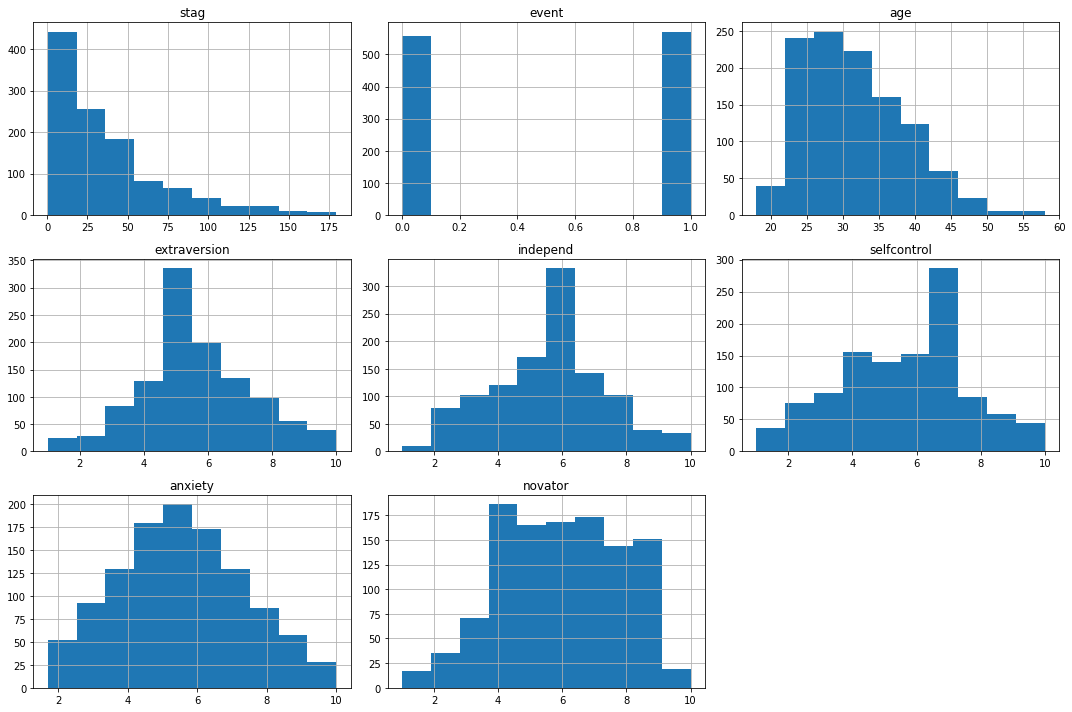

In [8]:
df1.hist(figsize=(15, 10))
plt.tight_layout()  # To avoid overlap of histograms
plt.show()

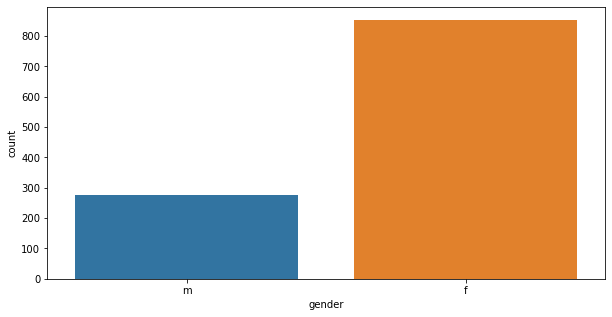

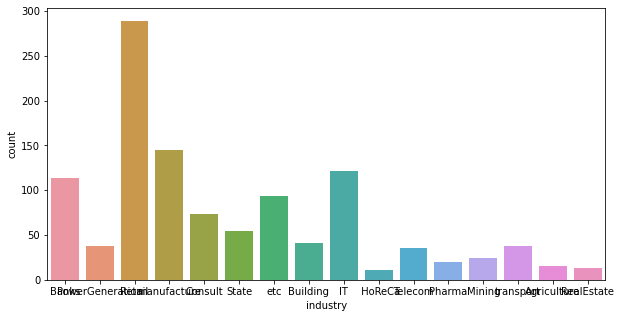

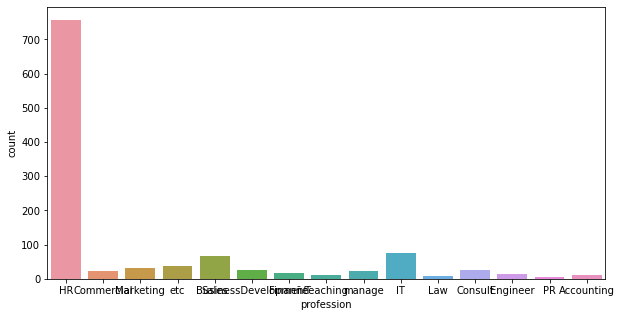

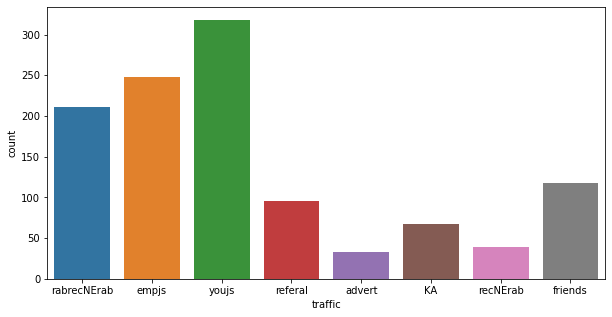

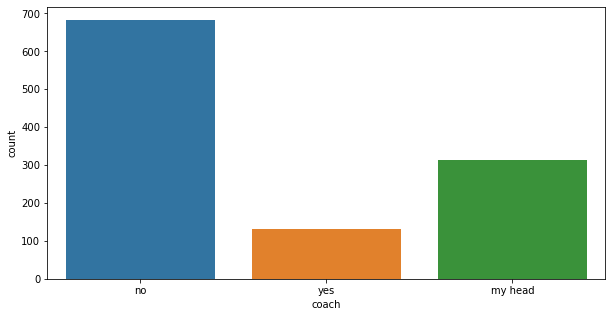

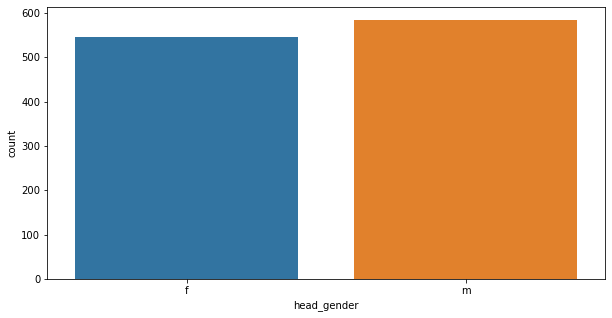

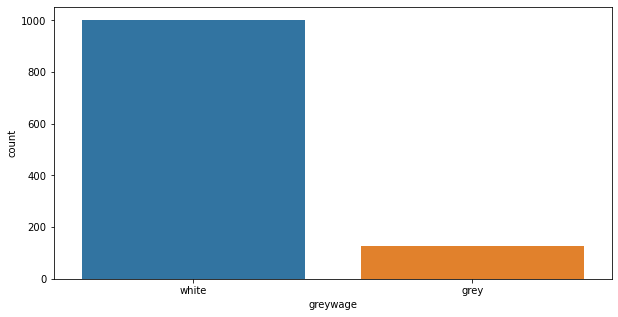

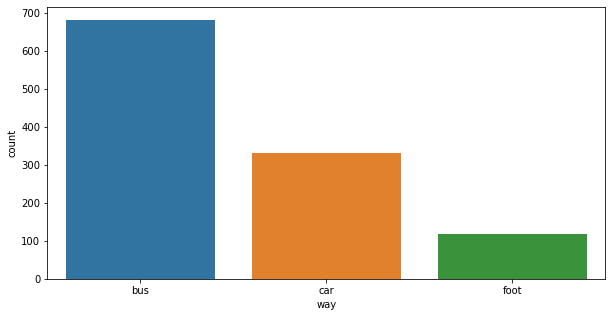

In [9]:
for col in df1.select_dtypes(include='object').columns:
    plt.figure(figsize=(10,5))
    sns.countplot(data=df1, x=col)
    plt.show()

In [10]:
# make correlation chart

Created years tenured variable instead of stag for ease of modeling

In [11]:
df1['years_tenured'] = df1['stag'] / 12

In [12]:
df1.drop('stag', axis = 1, inplace = True)

In [13]:
df1.head()

,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator,years_tenured
0,1,m,35.0,Banks,HR,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3,0.585900
1,1,m,33.0,Banks,HR,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3,1.913758
2,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3,1.327858
3,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7,1.327858
4,1,m,32.0,Retail,Commercial,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7,0.700890


Create a binary coach variable (replaces "my head" with yes) for ease of modeling

In [14]:
df1['coach'] = df1['coach'].replace('my head', 'yes')
df1.head()

,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator,years_tenured
0,1,m,35.0,Banks,HR,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3,0.585900
1,1,m,33.0,Banks,HR,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3,1.913758
2,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3,1.327858
3,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7,1.327858
4,1,m,32.0,Retail,Commercial,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7,0.700890


## Time for Preprocessing

In [15]:
X = df1.drop(columns='event')
y = df1.event

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

Split the data into categorical and numerical for scaling

In [17]:
categorical_features = ['gender', 'industry', 'profession', 'traffic', 'head_gender', 'greywage', 'way', 'coach']
numerical_features = ['age', 'extraversion', 'independ', 'selfcontrol', 'anxiety', 'novator', 'years_tenured']

Encoding categorical variables

In [18]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

X_train_encoded = encoder.fit_transform(X_train[categorical_features])
X_test_encoded = encoder.transform(X_test[categorical_features])

In [19]:
encoder.get_feature_names

<bound method OneHotEncoder.get_feature_names of OneHotEncoder(handle_unknown='ignore', sparse=False)>

In [20]:
X_train_cat = pd.DataFrame(columns=encoder.get_feature_names(categorical_features), data = X_train_encoded)

Getting column names for future plotting

In [21]:
column_names = numerical_features + X_train_cat.columns.tolist()

Scaling the Data

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_features])
X_test_scaled = scaler.transform(X_test[numerical_features])

In [23]:
X_train_ready = np.hstack([X_train_encoded, X_train_scaled])
X_test_ready = np.hstack([X_test_encoded, X_test_scaled])

# MODELING

## Logistic Regression

In [24]:
logreg = LogisticRegression()
model_log = logreg.fit(X_train_ready, y_train)

In [25]:
print(model_log) 

LogisticRegression()


In [26]:
# Get the model coefficients
coefficients = model_log.coef_

# Get the feature/variable names

coef_df = pd.DataFrame({'features': column_names, 'coefficients': coefficients[0]})

# Sort the DataFrame by coefficients
coef_df = coef_df.sort_values(by='coefficients')
# print out the dataframe
print(coef_df)

                          features  coefficients
24              industry_transport     -0.883252
34            profession_Marketing     -0.864553
25           profession_Accounting     -0.853899
7                         gender_f     -0.807341
10            industry_Agriculture     -0.447404
36                profession_Sales     -0.410387
11                  industry_Banks     -0.404838
31                   profession_HR     -0.385234
47                   traffic_youjs     -0.345416
19                 industry_Retail     -0.331085
29             profession_Engineer     -0.318338
50                   greywage_grey     -0.194543
56                       coach_yes     -0.173184
14                     industry_IT     -0.148339
41                  traffic_advert     -0.130852
17        industry_PowerGeneration     -0.125197
54                        way_foot     -0.123185
40                      traffic_KA     -0.110659
1                     extraversion     -0.100712
12               ind

Score the Logistic Regression

In [27]:
from sklearn.metrics import accuracy_score

y_pred_logreg = logreg.predict(X_test_ready)
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg)}")

Accuracy: 0.668141592920354


## Next Steps: After our preliminary model, we want to dive deeper to raise our model metrics and find specific features after that. Here are some things we'd ideally like to look at:
1. Next we want to try looking at feature importance, which we can do through a random forest model, random classification trees
    evaluate tradeoff between performance and complexity
2. Look at class imbalance: For instance, HR has a massive majority over the other fields. Try undersampling
3. Hyperparameter tuning
4. NEEED to make the coach variable binary
5. Need to do more advanced plots
6. Keep business problem in mind

Decision Tree Modeling

In [28]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import sys
import matplotlib
matplotlib.use('Agg')
# matplotlib.pyplot.savefig('filename')

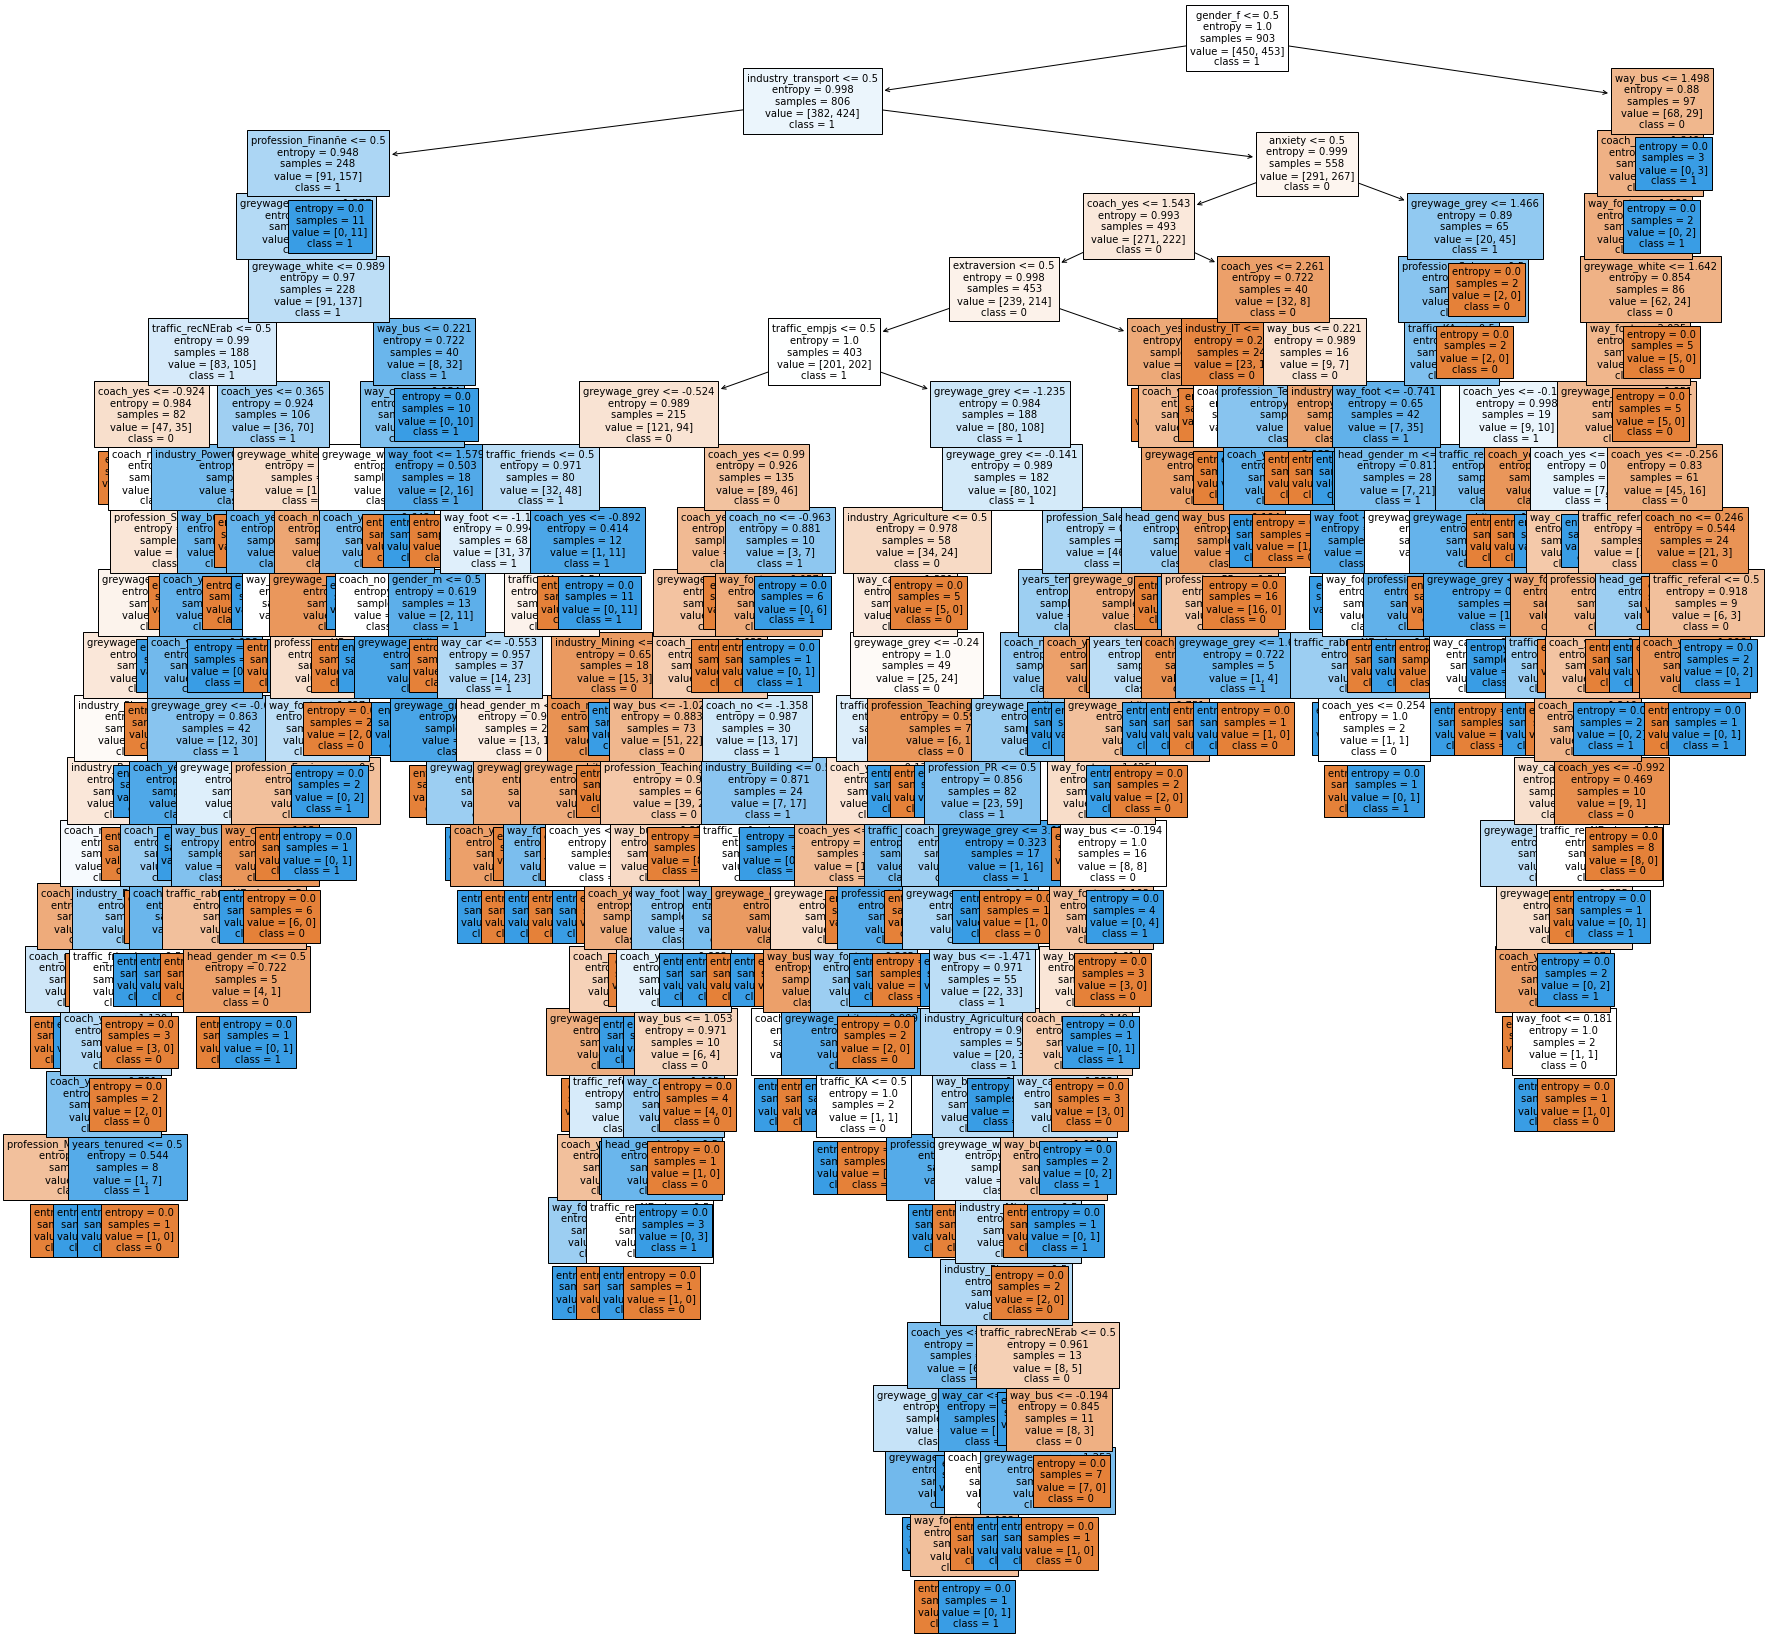

In [29]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import numpy as np
import sys

dtree = DecisionTreeClassifier(criterion='entropy')
dtree = dtree.fit(X_train_ready, y_train)
y_pred_dtree = dtree.predict(X_test_ready)

# Create a larger figure
plt.figure(figsize=(30,30))

# Plot the tree
plot_tree(dtree, 
    feature_names=column_names,
    class_names=np.unique(y).astype('str'),
    filled=True,
    fontsize=10)  # you can also increase the font size if it helps

# Save the figure
plt.savefig("Decision_Tree")
sys.stdout.flush()


In [30]:
print('Accuracy:', accuracy_score(y_test, y_pred_dtree))

Accuracy: 0.6371681415929203


Our accuracy went down, so we're going to move on to a more complex model

Random Forest Time!

In [31]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
rfc = RandomForestClassifier(n_estimators=100, 
                             max_depth=None,
                             random_state=42)

#fit data

rfc.fit(X_train_ready, y_train)

y_pred_rfc = rfc.predict(X_test_ready)

In [32]:
from sklearn.metrics import recall_score, precision_score, f1_score
# accuracy
print('Accuracy:', accuracy_score(y_test, y_pred_rfc))

# recall
recall = recall_score(y_test, y_pred_rfc)
print('Recall:', recall)

# precision
precision = precision_score(y_test, y_pred_rfc)
print('Precision:', precision)

# f1 score
f1 = f1_score(y_test, y_pred_rfc)
print('F1 Score:', f1)

Accuracy: 0.7212389380530974
Recall: 0.6694915254237288
Precision: 0.7669902912621359
F1 Score: 0.7149321266968326


Out of all of the statistics, our precision was highest. Precision is all about the correctness of positive predictions made by your model. High precision indicates that our model is highly accurate when it predicts that an employee will churn.

Feature Importances

<AxesSubplot:>

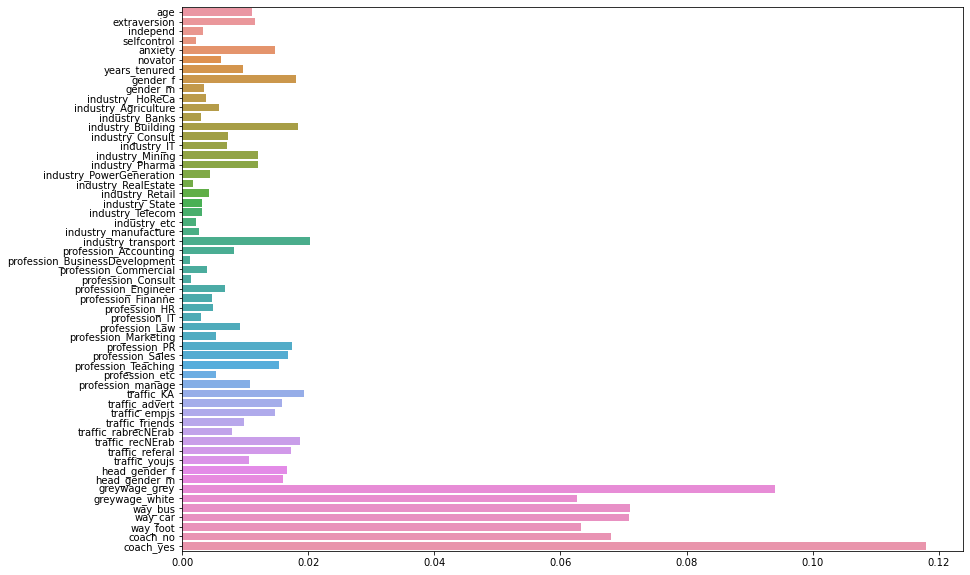

In [33]:
plt.figure(figsize=(14,10))
sns.barplot(y = column_names, x = rfc.feature_importances_)

Notes here:
1. Having a coach seems to be the most important variable, followed by your wage (unsurprisingly) and the type of commute you have.
2. In this dataset, being in real estate, consulting, or business development seems to have almost no effect on whether you will churn. 

Now that we have 

## Fine Tuning

In [34]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_ready, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print("Best parameters: ", best_params)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:   34.7s finished


Best parameters:  {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


## Final model with best attributes

In [35]:
rfc = RandomForestClassifier(n_estimators=100, 
                             max_depth=20,
                             min_samples_leaf=2,
                             min_samples_split=5,
                             random_state=42)

#fit data

rfc.fit(X_train_ready, y_train)

y_pred_rfc = rfc.predict(X_test_ready)

# accuracy
print('Accuracy:', accuracy_score(y_test, y_pred_rfc))

# recall
recall = recall_score(y_test, y_pred_rfc)
print('Recall:', recall)

# precision
precision = precision_score(y_test, y_pred_rfc)
print('Precision:', precision)

# f1 score
f1 = f1_score(y_test, y_pred_rfc)
print('F1 Score:', f1)

Accuracy: 0.7300884955752213
Recall: 0.6949152542372882
Precision: 0.7663551401869159
F1 Score: 0.7288888888888889


In [36]:
print(rfc)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       random_state=42)


In [37]:
len(rfc.estimators_)

100

In [38]:
rfc.estimators_[0]

DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=2,
                       min_samples_split=5, random_state=1608637542)

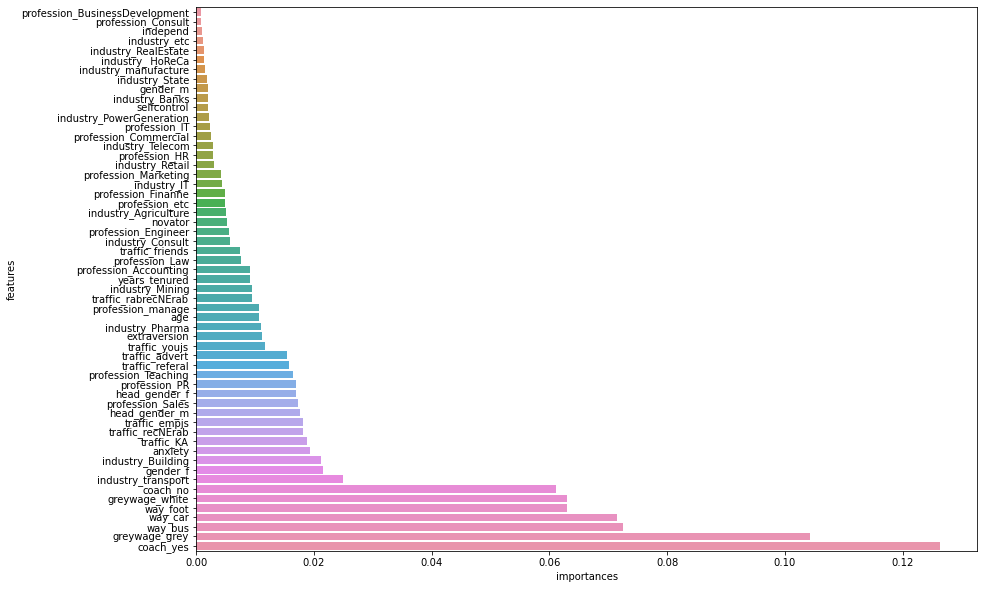

In [39]:
df = pd.DataFrame({'features': column_names, 'importances': rfc.feature_importances_})

# sort the dataframe by importances
df = df.sort_values('importances')

# plot
plt.figure(figsize=(14,10))
sns.barplot(y = df['features'], x = df['importances'])
plt.show()